# **Decoupler-GPU**
**Accelerated Transcriptional Regulatory Analysis**  

**Author:** [Severin Dicks](https://github.com/Intron7)
**Copyright** [scverse](https://scverse.org)

In this notebook, we explore the updated Decoupler functions for inferring transcriptional regulatory activity, leveraging the **GPU-accelerated** implementation from **rapids-singlecell**.

By running these analyses on GPUs, we achieve faster computation and scalability for large single-cell datasets.
We will apply **Decoupler** methods to estimate **transcription factor (TF) activity** and **pathway activity**, utilizing curated regulatory networks such as **CollecTRI**.

In [1]:
import rapids_singlecell as rsc
import scanpy as sc
import rmm
import cupy as cp
import pandas as pd
import anndata as ad
import decoupler as dc
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=True, # default is False
)
cp.cuda.set_allocator(rmm_cupy_allocator)

ℹ️ Note: The dataset used in this notebook is generated in `01_demo_gpu.ipynb`. 

In [2]:
adata = sc.read_h5ad("h5/dli_decoupler.h5ad")

In [3]:
adata = adata.raw.to_adata()

In [4]:
rsc.get.anndata_to_GPU(adata)

### CollecTRI network
CollecTRI is a comprehensive resource containing a curated collection of TFs and their transcriptional targets compiled from 12 different resources. This collection provides an increased coverage of transcription factors and a superior performance in identifying perturbed TFs compared to other literature based GRNs such as DoRothEA. Similar to DoRothEA, interactions are weighted by their mode of regulation (activation or inhibition).

In [5]:
collectri = dc.op.collectri(organism="human",license="commercial")

### Transcription Factor Activity Inference with ULM  

To infer transcription factor (TF) activity, we use the **Univariate Linear Model (ULM)** from **Decoupler**.  
ULM estimates the regulatory influence of TFs on gene expression by fitting a linear model for each TF-gene interaction.  

We apply **ULM** using the **Dorothea** regulatory network retrieved earlier. 

In [6]:
%%time
rsc.dcg.ulm(data=adata, net=collectri, verbose = True, raw=False, bsize=10000, tmin=3)

2025-08-06 16:03:14 | [INFO] ulm - Running ulm
2025-08-06 16:03:14 | [INFO] Network adjacency matrix has 5951 unique features and 881 unique sources


  0%|          | 0/22 [00:00<?, ?it/s]

2025-08-06 16:03:15 | [INFO] ulm - fitting 881 univariate models of 25430 observations (targets) with 25428 degrees of freedom
2025-08-06 16:03:26 | [INFO] ulm - adjusting p-values by FDR
2025-08-06 16:03:31 | [INFO] ulm - done


CPU times: user 16.4 s, sys: 610 ms, total: 17 s
Wall time: 17 s


In [7]:
score = dc.pp.get_obsm(adata=adata, key="score_ulm")

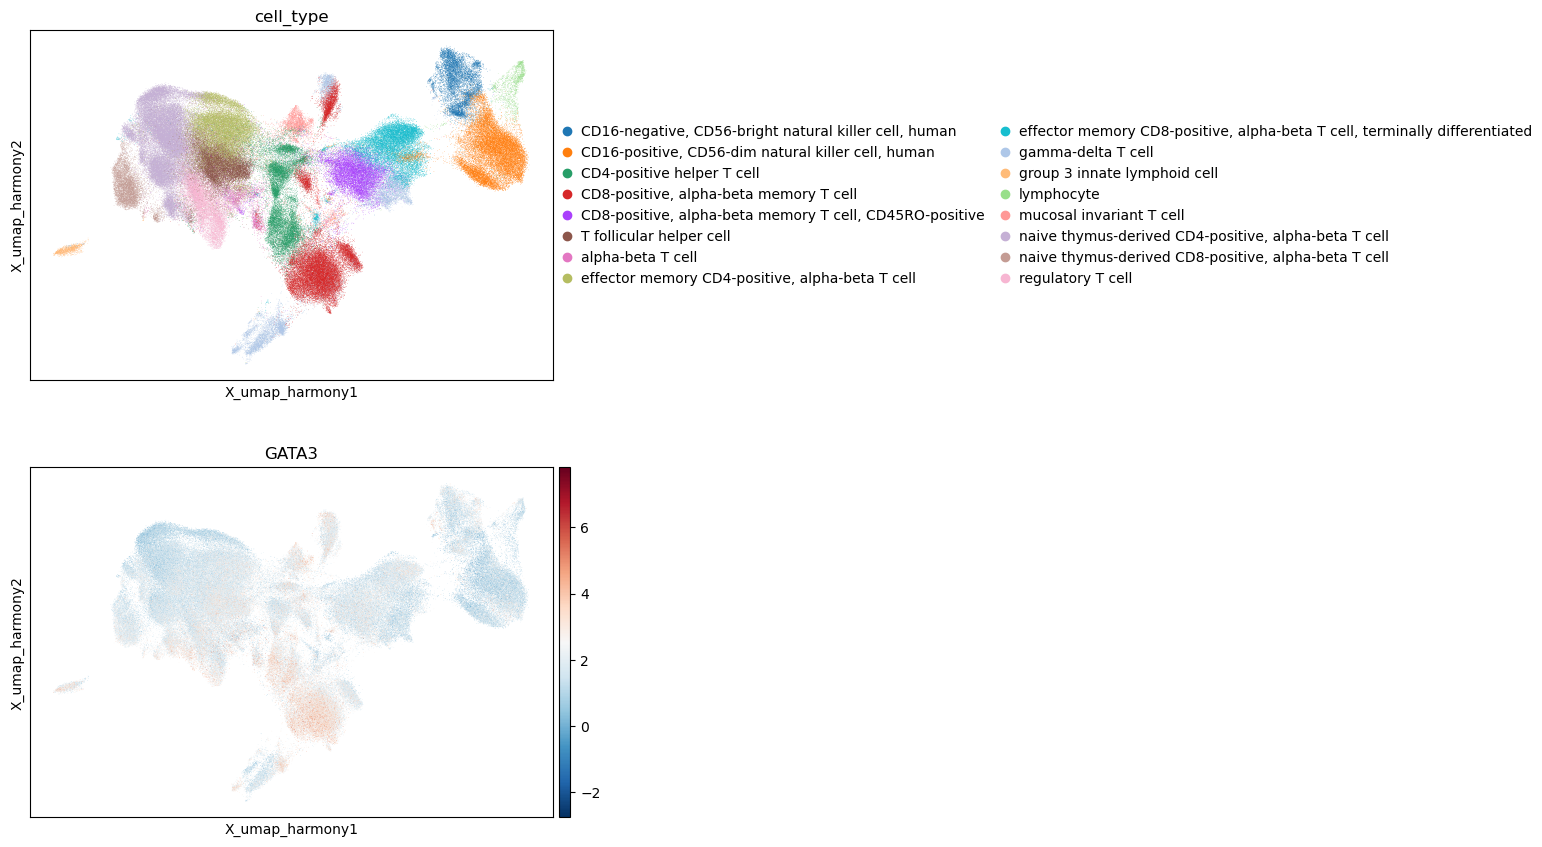

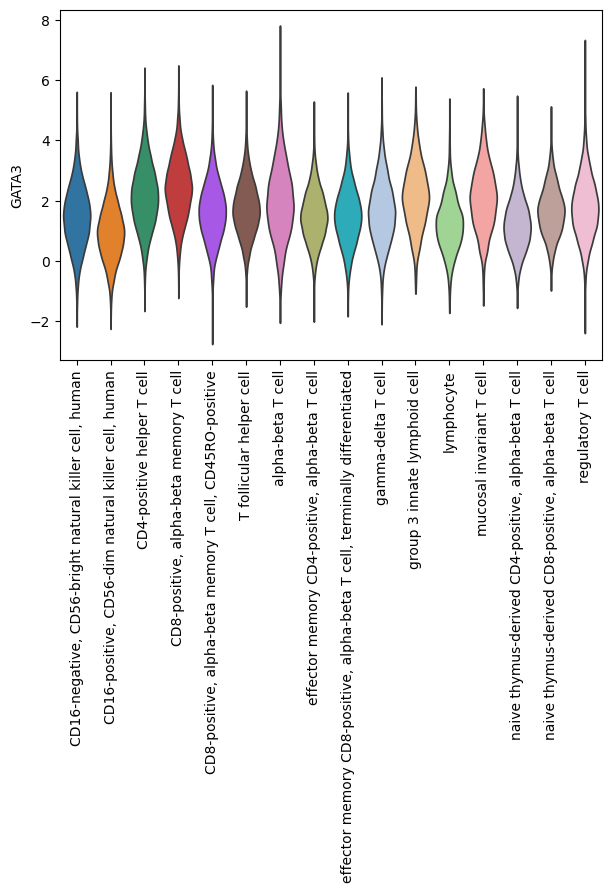

In [8]:
sc.pl.embedding(score,basis="X_umap_harmony", color=["cell_type", "GATA3"], cmap='RdBu_r',ncols=1)
sc.pl.violin(score, keys=['GATA3'], groupby='cell_type', rotation=90, size = 0)


### Transcription Factor Activity Inference with MLM  

Next, we infer transcription factor (TF) activity using the **Multivariate Linear Model (MLM)** from **Decoupler**.  
Unlike **ULM**, which considers each TF independently, **MLM** accounts for multiple TFs simultaneously,  
providing a more comprehensive estimation of regulatory influences. 

In [9]:
%%time
rsc.dcg.mlm(data=adata, net=collectri, verbose = True, raw=False, bsize=10000, tmin=3)

2025-08-06 16:03:34 | [INFO] mlm - Running mlm
2025-08-06 16:03:35 | [INFO] Network adjacency matrix has 5951 unique features and 881 unique sources


  0%|          | 0/22 [00:00<?, ?it/s]

2025-08-06 16:03:35 | [INFO] mlm - fitting 881 multivariate models of 25430 observations with 24548 degrees of freedom
2025-08-06 16:03:50 | [INFO] mlm - done


CPU times: user 14.1 s, sys: 1.19 s, total: 15.3 s
Wall time: 15.2 s


### Transcription Factor Activity Inference with AUCell  

Next, we infer transcription factor (TF) activity using **AUCell** from **Decoupler**.  
AUCell estimates TF activity based on the **enrichment of TF target genes within the top-expressed genes** in each cell.  
Unlike regression-based methods (**ULM**, **MLM**), AUCell is a **rank-based approach** that does not assume linear relationships. 

In [10]:
%%time
rsc.dcg.aucell(data=adata, net=collectri, verbose = True, raw=False, bsize=5000, tmin=3)

2025-08-06 16:03:50 | [INFO] aucell - Running aucell
2025-08-06 16:03:50 | [INFO] Network has 5951 unique features and 881 unique sources


  0%|          | 0/43 [00:00<?, ?it/s]

2025-08-06 16:03:50 | [INFO] aucell - calculating 881 AUCs for 25430 targets across 5000 observations, categorizing features at rank=1272
2025-08-06 16:04:21 | [INFO] aucell - done


CPU times: user 31.2 s, sys: 152 ms, total: 31.4 s
Wall time: 31.3 s


In [11]:
score = dc.pp.get_obsm(adata=adata, key="score_aucell")

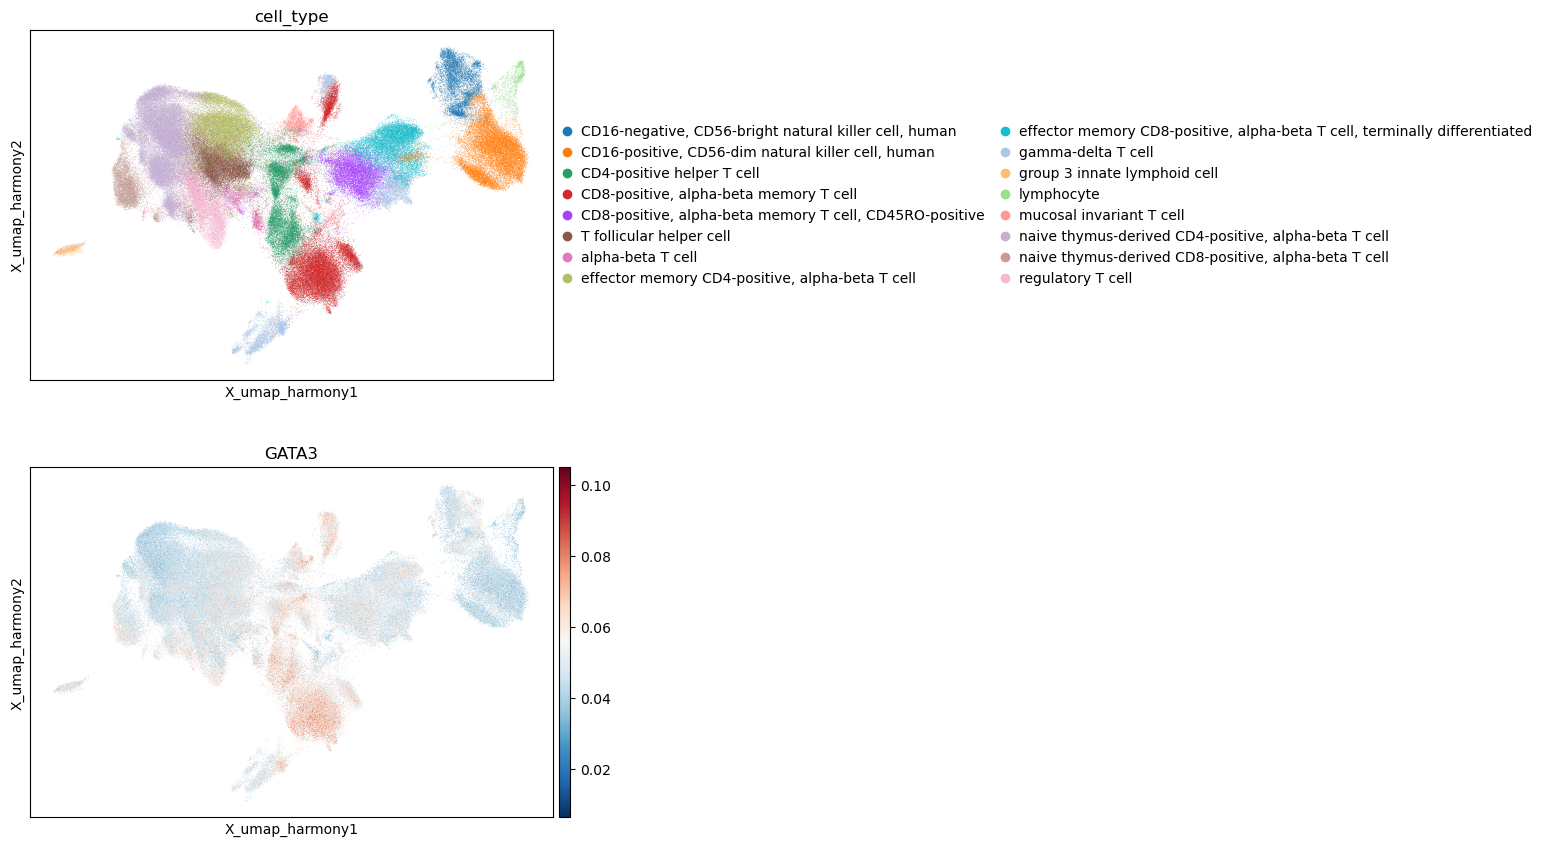

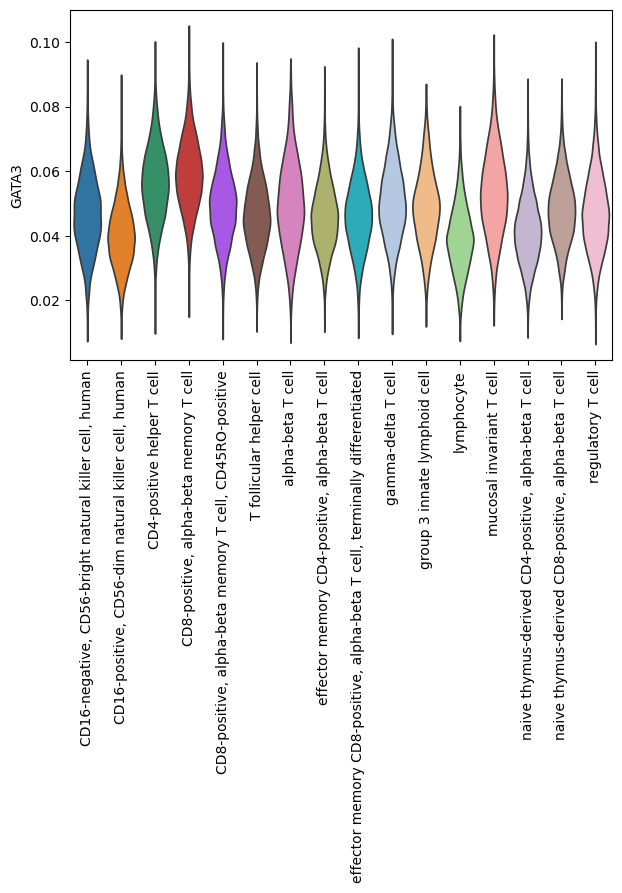

In [12]:
sc.pl.embedding(score,basis="X_umap_harmony", color=["cell_type", "GATA3"], cmap='RdBu_r',ncols=1)
sc.pl.violin(score, keys=['GATA3'], groupby='cell_type', rotation=90, size = 0)


In [13]:
model = pd.read_parquet("nets/progeny.parquet")